# 一般思路
1.读取rgb图片  
2.将rgb图片变为灰度图片  
3.使用LBP进行特征提取  
4.LBP特征提取结果转换回tensor格式  

In [1]:
#用于读取图像
from PIL import Image 

#用于PIL、tensor等图像格式转换
import torch
from torchvision import transforms 

# 用于进行LBP手工特征提取
from skimage import feature # pip install scikit-image

### 1.通过PIL读取RGB图像

图片变量 = Image.open('图像路径.jpg').convert('RGB')


(256, 256)


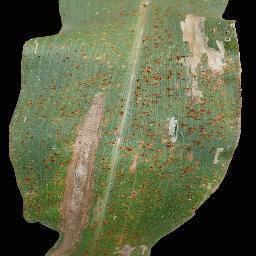

In [2]:
# 1.通过PIL读取图像

img = Image.open('2.jpg').convert('RGB')

print(img.size)
img

### 2.图像转换为灰度图

图片变量 = 图片变量.convert('L')

In [3]:
# 2.图像转换为灰度图

img = img.convert('L') 

img.show()

### 3.LBP特征提取

> local_binary_pattern(image, P, R, method='default')

>>image：（N，M）阵列灰度图像。（只能是灰度图）  
>>P：int圆对称邻居设置点的数量（角度空间的量化）  
>>R：float圆的半径（操作员空间分辨率）  
>>method：{‘default’，‘ror’，‘uniform’，‘var’}确定模式的方法(调参使用)  

>>输出：（N，M）阵列LBP图像

In [4]:
# 3.LBP特征提取

# ------------
# pip install scikit-image
# local_binary_pattern(image, P, R, method='default')

# image：（N，M）阵列灰度图像。（只能是灰度图）
# P：int圆对称邻居设置点的数量（角度空间的量化）。
# R：float圆的半径（操作员空间分辨率）。
# method：{‘default’，‘ror’，‘uniform’，‘var’}确定模式的方法(调参使用)

# 输出：（N，M）阵列LBP图像
# ------------
from skimage import feature

radius = 1 # LBP算法中范围半径的取值
n_points = 8 * radius # 领域像素点数

lbp = feature.local_binary_pattern(img,n_points,radius,'default')

   

In [5]:
print(lbp)
print(lbp.shape)

[[193. 241. 241. ... 241. 241. 112.]
 [199. 255. 255. ... 255. 255. 124.]
 [199. 255. 255. ... 255. 255. 124.]
 ...
 [199. 255. 255. ... 255. 255. 124.]
 [199. 255. 255. ... 255. 255. 124.]
 [  7.  31.  31. ...  31.  31.  28.]]
(256, 256)


### 4.把提取的特征结果转换成tensor格式[C,W,H]

In [6]:
# 4.把提取的特征结果转换成tensor格式[C,W,H]

import torch

lbp = torch.tensor(lbp)
lbp = lbp.reshape(1,256,256)

print(lbp)
print(lbp.shape)

tensor([[[193., 241., 241.,  ..., 241., 241., 112.],
         [199., 255., 255.,  ..., 255., 255., 124.],
         [199., 255., 255.,  ..., 255., 255., 124.],
         ...,
         [199., 255., 255.,  ..., 255., 255., 124.],
         [199., 255., 255.,  ..., 255., 255., 124.],
         [  7.,  31.,  31.,  ...,  31.,  31.,  28.]]], dtype=torch.float64)
torch.Size([1, 256, 256])


### 5.将tensor转换为PIL图像格式并生成图像，查看lbp提取结果

In [7]:
# 输入tensor变量
# 输出PIL格式图片

from torchvision import transforms

out = transforms.ToPILImage()(lbp)
out.show()

# SAM + LBP 思路
1.将输入的batch中图片放入SAM消除通道维度，输出维度（b,1,w,h)  
2.依次读取batch中的图片，将其格式转换为numpy，维度变为(w,h),使用LBP进行处理，处理结果放入一个空列表中  
3.将存放batch内所有图片LBP处理结果的列表转换为tensor格式  
4.将维度变回（b,1,w,h)

In [8]:
#导包
import cv2 as cv
import torch
from torch import nn
from skimage import feature

import numpy as np

### 1.网络构建

In [9]:
# 空间注意力SAM

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'  # 卷积核conv layer大小必须为3或7
        padding = 3 if kernel_size == 7 else 1   # 当卷积核大小为7时，输入的每一条边补充3的层数；当卷积核大小为3时，输入的每一条边补充1的层数

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)  # 卷积：输入维度2[MaxPool,AvgPool]，输出维度1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)    # 1.在每一个特征点的通道上取平均值(图片中同一像素点上的不同维度平均值) 结果消除通道c维度
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # 1.在每一个特征点的通道上取最大值(图片中同一像素点上的不同维度最大值) 结果消除通道c维度

        x = torch.cat([avg_out, max_out], dim=1)  # 2.通道维度堆叠
        x = self.conv1(x)  # 2.利用一次通道数为1的卷积调整通道数，变成特征图

        return x  


In [10]:
# 主干网络

class LBP_SAM(nn.Module):
    # 可学习参数的层（如全连接层、卷积层等）
    def __init__(self):
        super().__init__()
        
        # 空间注意力机制消除通道维度
        self.attention = SpatialAttention()
  
      
    # 实现模型的功能，实现各个层之间的连接关系
    # nn.functional实现不具有可学习参数的层(如ReLU、dropout、BatchNormanation层)的构造
    def forward(self, x):
        b,c,w,h = x.shape
        
        # SAM，取出图片的通道维度c
        x = self.attention(x)
        print("SAM后数据格式:",x.shape)
        
        batch = []
        for i in x:
            
            # --------------------------------------------------------------
#             # 不适用SAM，将tensor转换成PIL,利用PIL直接将图片转换为二值图像
#             i = transforms.ToPILImage()(i)
#             i = i.convert('L') 
            # --------------------------------------------------------------
            
            # --------------------------------------------------------------
            # 使用SAM 
            i = i.reshape(w,h) # 维度变换
            i = i.detach().numpy() # tensor转换为numpy
            # --------------------------------------------------------------
            
            lbp = feature.local_binary_pattern(i,1,8,'default')
            batch.append(lbp)
        
        lbp = torch.tensor(lbp)
        lbp = lbp.reshape(b,1,w,h)
        
        
        return lbp
        
        

In [11]:
from torchsummary import summary 

# 实例化模型
model = LBP_SAM()
#model = model.float()

# 查看模型
print(model)
#print(summary(model, (3,256,256)))

LBP_SAM(
  (attention): SpatialAttention(
    (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
)


### 2.读取图片并将图片PIL格式转换为tensor格式

(256, 256)


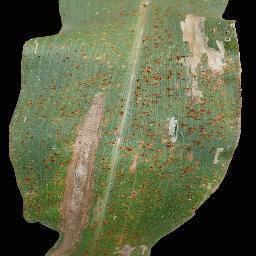

In [12]:
from PIL import Image

img = Image.open('2.jpg').convert('RGB')

print(img.size)
img


In [13]:
# PIL图片转换成tensor格式

from torchvision import transforms

trans = transforms.Compose([
    transforms.Resize(256),  # 缩放图片Image，保持长宽比不变，最短边为32像素
    transforms.CenterCrop(256),  #从图片中间切出32*32图片
    transforms.ToTensor(),  # 将图片Image转成Tensor格式(通道,高,宽),并归一化至[0,1]
])


img = trans(img)

print(img)
print(img.shape)


tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.

In [14]:
img = img.reshape(1,3,256,256)

### 3.将图片放入网络

In [15]:
# 初始化模型
model = LBP_SAM()

out = model(img)

print(out)
print(out.shape)

SAM后数据格式: torch.Size([1, 1, 256, 256])
tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 1.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], dtype=torch.float64)
torch.Size([1, 1, 256, 256])


In [16]:
# 输出图像

out = transforms.ToPILImage()(out[0])
out.show()

# CV2、PIL、tensor格式互相转换

In [17]:
# 利用PIL或CV2转换图像

In [18]:
# 直接转换为黑白图像
image_file = Image.open("2.jpg") 
image_file = image_file.convert('1') 
image_file
image_file.show()

In [19]:

import cv2
 
image = cv2.imread('2.jpg', cv2.IMREAD_GRAYSCALE)
cv2.imwrite('test.jpg', image)

True

In [20]:
print(image.size)

65536


# 特征融合

In [21]:
import torch
import numpy as np

x = torch.rand(3,1,3,3)
print(x)

tensor([[[[0.9050, 0.2436, 0.9951],
          [0.8666, 0.1266, 0.5352],
          [0.7375, 0.9670, 0.2569]]],


        [[[0.3900, 0.1170, 0.4966],
          [0.6756, 0.4424, 0.0770],
          [0.6797, 0.4566, 0.6433]]],


        [[[0.3460, 0.1091, 0.8445],
          [0.7772, 0.1241, 0.1763],
          [0.7234, 0.2365, 0.1125]]]])


In [22]:
batch = []
for i in x:
    i = i.reshape(3,3)
    i = i.detach().numpy() 
    
    i = i/2
    print(i)
    print(i.shape)
    batch.append(i)

[[0.45251235 0.12181637 0.49753547]
 [0.433282   0.06331512 0.2676222 ]
 [0.3687413  0.48352224 0.12845933]]
(3, 3)
[[0.19497862 0.05851114 0.24831271]
 [0.33781537 0.22117981 0.03850001]
 [0.33984995 0.22829613 0.3216356 ]]
(3, 3)
[[0.17299965 0.05453002 0.42224553]
 [0.38858923 0.06205803 0.08815894]
 [0.36171898 0.11826342 0.05626887]]
(3, 3)


In [23]:
#batch = np.array(batch)

batch = torch.tensor(batch)
print(batch)



tensor([[[0.4525, 0.1218, 0.4975],
         [0.4333, 0.0633, 0.2676],
         [0.3687, 0.4835, 0.1285]],

        [[0.1950, 0.0585, 0.2483],
         [0.3378, 0.2212, 0.0385],
         [0.3398, 0.2283, 0.3216]],

        [[0.1730, 0.0545, 0.4222],
         [0.3886, 0.0621, 0.0882],
         [0.3617, 0.1183, 0.0563]]])


In [24]:
batch = batch.reshape(3,1,3,3)
print(batch)
print(batch.shape)

tensor([[[[0.4525, 0.1218, 0.4975],
          [0.4333, 0.0633, 0.2676],
          [0.3687, 0.4835, 0.1285]]],


        [[[0.1950, 0.0585, 0.2483],
          [0.3378, 0.2212, 0.0385],
          [0.3398, 0.2283, 0.3216]]],


        [[[0.1730, 0.0545, 0.4222],
          [0.3886, 0.0621, 0.0882],
          [0.3617, 0.1183, 0.0563]]]])
torch.Size([3, 1, 3, 3])


In [25]:
b,c,w,h = batch.shape
print(b)
print(c)

3
1


In [26]:
x = torch.rand(128,3)
y = torch.rand(128,9)

print(x)
print(y)

tensor([[0.7551, 0.9455, 0.4172],
        [0.1470, 0.5558, 0.0803],
        [0.2487, 0.6833, 0.9597],
        [0.7707, 0.4105, 0.9549],
        [0.8586, 0.1542, 0.8765],
        [0.6103, 0.1049, 0.4980],
        [0.3865, 0.1736, 0.9671],
        [0.6096, 0.1156, 0.2673],
        [0.6466, 0.9212, 0.5267],
        [0.8726, 0.4147, 0.5838],
        [0.9246, 0.3441, 0.8455],
        [0.6793, 0.4844, 0.8598],
        [0.9746, 0.3562, 0.4799],
        [0.3560, 0.9938, 0.7565],
        [0.2951, 0.9458, 0.0878],
        [0.8675, 0.2749, 0.2118],
        [0.3316, 0.2007, 0.4264],
        [0.0247, 0.4282, 0.3982],
        [0.9660, 0.9212, 0.5179],
        [0.7284, 0.9604, 0.6536],
        [0.6623, 0.9033, 0.9058],
        [0.1697, 0.9009, 0.6163],
        [0.5530, 0.4449, 0.2582],
        [0.3011, 0.6907, 0.2365],
        [0.7274, 0.8213, 0.9647],
        [0.6826, 0.2280, 0.8321],
        [0.0528, 0.3611, 0.7175],
        [0.0147, 0.5612, 0.7258],
        [0.1875, 0.9659, 0.3482],
        [0.377

In [27]:
out = torch.cat([x,y], dim=1)

In [28]:
print(out)
print(out.shape)

tensor([[0.7551, 0.9455, 0.4172,  ..., 0.8055, 0.1980, 0.1105],
        [0.1470, 0.5558, 0.0803,  ..., 0.4423, 0.3532, 0.4335],
        [0.2487, 0.6833, 0.9597,  ..., 0.8225, 0.7001, 0.5617],
        ...,
        [0.9412, 0.2097, 0.9300,  ..., 0.1313, 0.0857, 0.9809],
        [0.0348, 0.4105, 0.6433,  ..., 0.6577, 0.3282, 0.1622],
        [0.9687, 0.6950, 0.0134,  ..., 0.7621, 0.0757, 0.8831]])
torch.Size([128, 12])
